# Preprocess interesting timeseries

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.002_Gc=0.7_ggap=1.0_gsyn=1.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.875_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263


/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


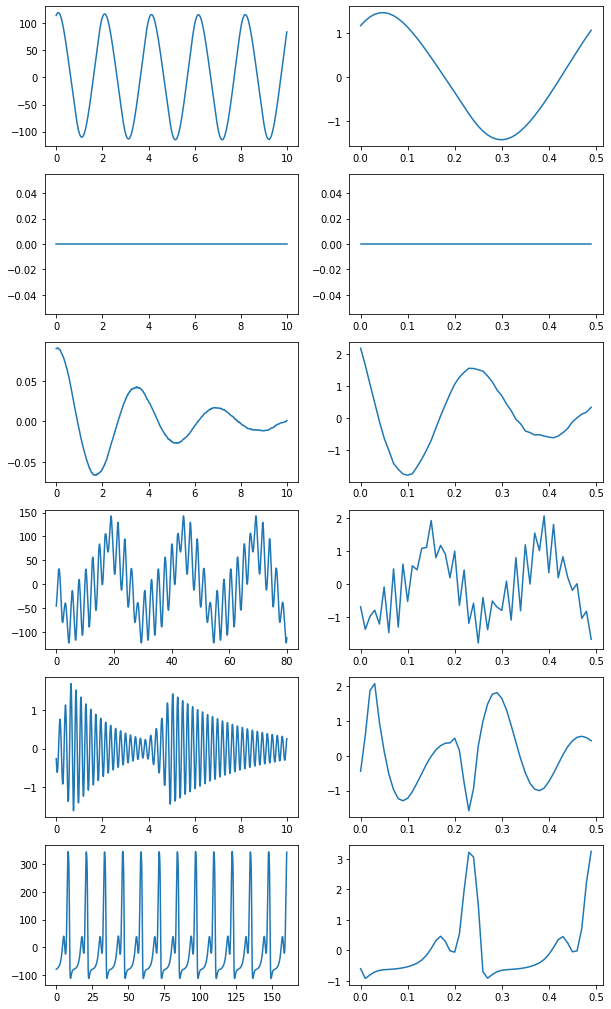

In [77]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from tslearn.utils import to_time_series
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
last_n_percent = 0.50
C_actual = 0.015
Gc_actual = 0.1

def get_dom_mode(ggap, gsyn, C = C_actual, Gc = Gc_actual):
  all_dynamics = simulate_until_stable(
    C = C,
    Gc = Gc,
    ggap = ggap,
    gsyn = gsyn)
  n = all_dynamics.shape[0]
  
  last_dynamics = all_dynamics[-int(last_n_percent * n):,:]
  
  # If we don't round off, minor numerical stability
  # will make us misidentify a stable node for an oscillation
  last_dynamics = np.round(last_dynamics, 3)
  
  pca = PCA(n_components = 1)
  # Perform mean-centering before PCA
  X = last_dynamics - last_dynamics.mean(axis= 0)
  projected_X = pca.fit_transform(last_dynamics)
  return projected_X[:,0]

def preprocess_ts(ts):
  # Scale to mean 0 variance 1. We want similar looking-graphs, no matter the amplitude,
  # to be grouped together
  fft_period = get_period(ts)
  # Times 100 because the period is in seconds, but our array timescale is 0.01s for each index.
  # Times 2 because we want to see multiple periods to distinguish between focus and stable oscillation.
  if np.isfinite(fft_period):
    ts = ts[-int(fft_period) * 100 * 2:]
  ts = TimeSeriesScalerMeanVariance().fit_transform(ts)
  # Make time series shorter for faster processing.
  # Disadvantage is that we will lose the smoothness vs sharpness info.
  ts = TimeSeriesResampler(sz=50).fit_transform(ts)
  ts = ts.reshape(-1)
  return ts

def plot_ts(ax, ts):
  times = np.arange(0, ts.shape[0] * 0.01 , 0.01)
  ax.plot(times, ts)
  
ts_simple_oscillation = get_dom_mode(ggap = 1.0, gsyn = 1.0)
ts_stable_node = get_dom_mode(ggap = 0.0, gsyn = 0.0)
ts_stable_focus = get_dom_mode(C = 0.002, Gc = 0.7, ggap = 1.0, gsyn = 1.0)
ts_nested_oscillation_mean_shift = get_dom_mode(ggap = 0.875, gsyn = 1.5)
ts_nested_oscillation_amplitude_shift = get_dom_mode(ggap = 0.0789, gsyn = 1.1842)
ts_spike = get_dom_mode(ggap = 0.1579, gsyn = 1.2632)

ts_list = \
  [
    ts_simple_oscillation,
    ts_stable_node,
    ts_stable_focus,
    ts_nested_oscillation_mean_shift,
    ts_nested_oscillation_amplitude_shift,
    ts_spike
  ]

fig, axes = plt.subplots(nrows=len(ts_list), ncols=2, figsize=(10, 3 * len(ts_list)))

for row in range(len(ts_list)):
  ts = ts_list[row]
  preprocessed_ts = preprocess_ts(ts)
  plot_ts(axes[row][0], ts)
  plot_ts(axes[row][1], preprocessed_ts)

# Kmeans clustering

In [78]:
ggap_lo = 0.0
ggap_hi = 1.5
gsyn_lo = 0.0
gsyn_hi = 1.5
num_points = 20

ts_list = []
params_list = []
for ggap in np.linspace(ggap_lo, ggap_hi, num_points):
  for gsyn in np.linspace(gsyn_lo, gsyn_hi, num_points):
    dom_ts = get_dom_mode(ggap, gsyn)
    ts = preprocess_ts(dom_ts)
    ts_list.append(ts)
    params_list.append((ggap, gsyn))
ts_list = np.array(ts_list)
params_list = np.array(params_list)

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simu

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simu

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeW

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.263
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.553
Loading saved results from pickle file cached_notebook_res

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=1.421
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]
/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=1.026
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.316_gsyn=1.105
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.395_gsyn=1.184
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.474_gsyn=0.632
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.553_gsyn=1.342
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.632_gsyn=1.184
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.711_gsyn=1.026
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.789_gsyn=0.632
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.868_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.947_gsyn=1.5
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.079
Loading saved results from pickle file cached_notebook_resul

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.026_gsyn=0.789
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.105_gsyn=1.342
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.105
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.342
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.421
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.184_gsyn=1.5
Loading saved results from pickle file cached_notebook_res

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.789
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.868
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=1.026
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.263_gsyn=1.105
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.342_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.421_gsyn=0.711
Loading saved results from pickle file cached_notebook_r

/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/analysis_util.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  per_1 = 1./freq_1[0]


Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.237
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.316
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.474
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.553
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.632
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=1.5_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_si

12.527 --> 9.750 --> 9.428 --> 9.169 --> 9.094 --> 9.073 --> 9.048 --> 9.028 --> 9.019 --> 9.009 --> 9.004 --> 9.004 --> 
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.711
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.237_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.316


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/pca.py:536: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures hav

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.263
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.474


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/plot_util.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning,

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.947
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.553


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.158_gsyn=0.395


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=1.184
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.868


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/Documents/code/c-elegans-interactome-analysis/util/plot_util.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly close

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.079
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.158
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=1.184


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.079_gsyn=0.395
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=0.1_ggap=0.0_gsyn=0.947


/home/stephen/Documents/code/c-elegans-interactome-analysis/util/plot_util.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))


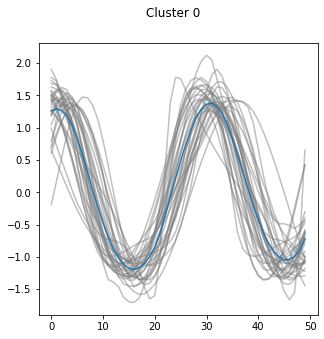

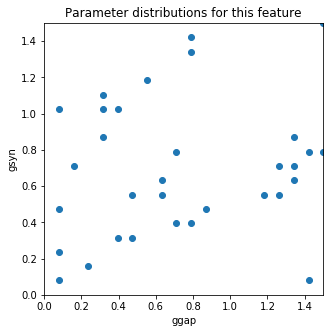

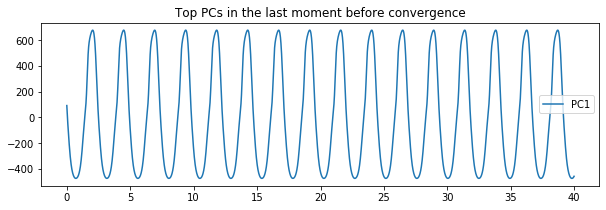

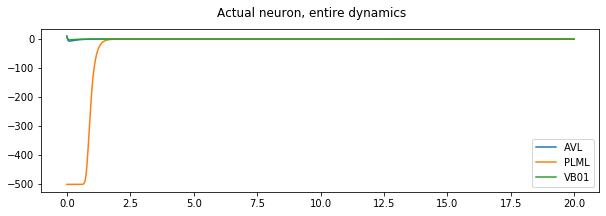

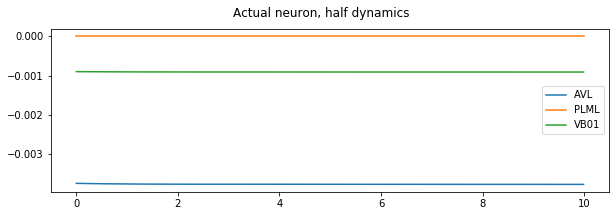

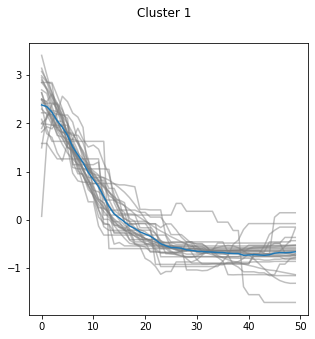

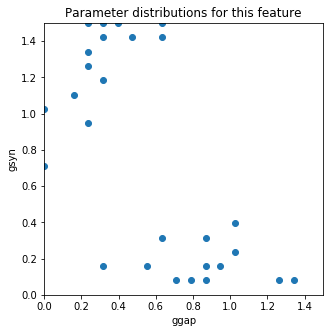

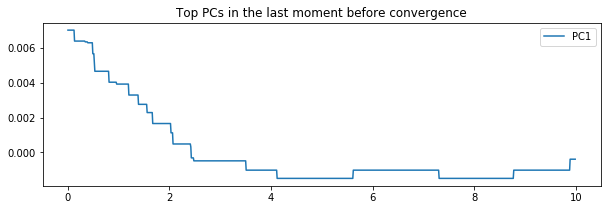

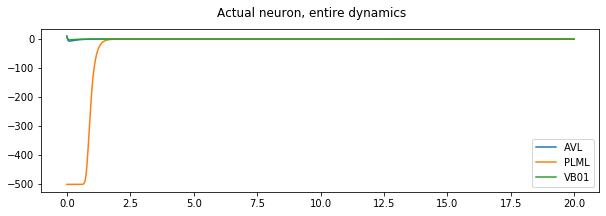

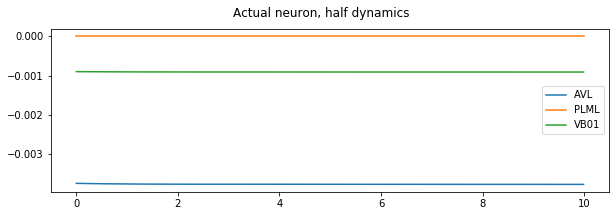

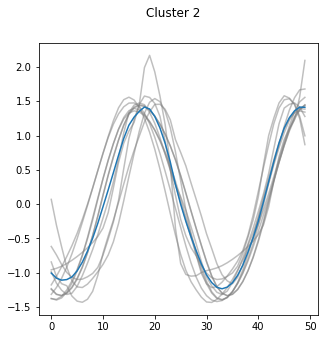

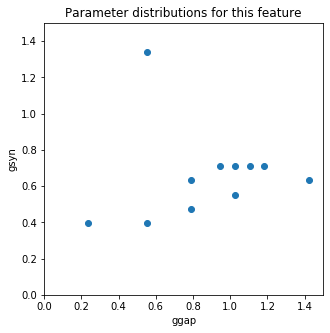

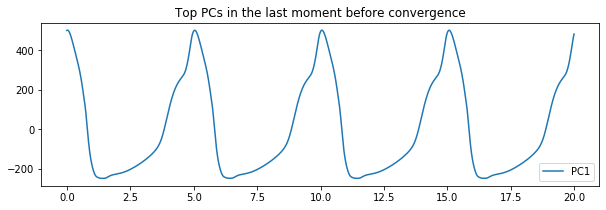

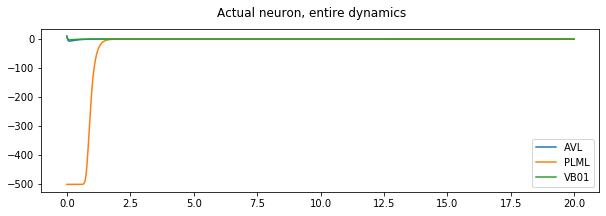

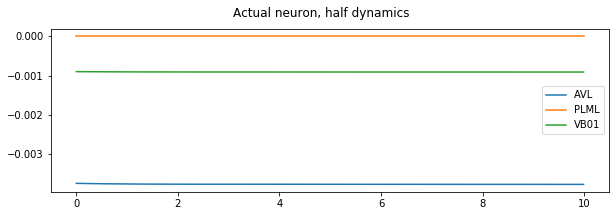

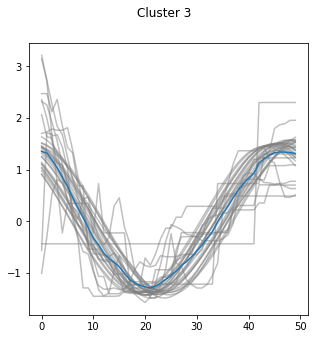

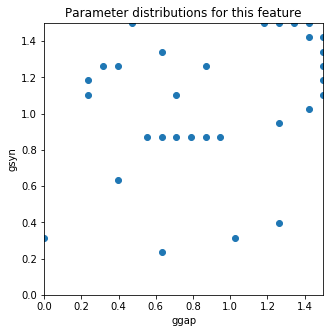

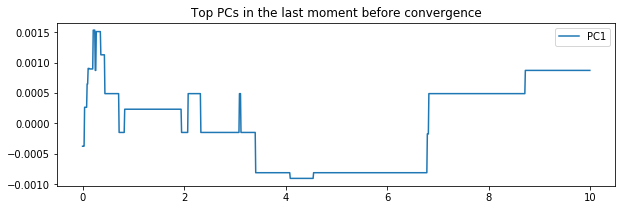

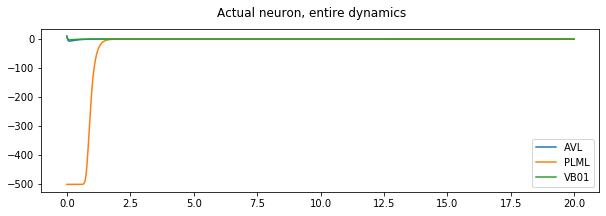

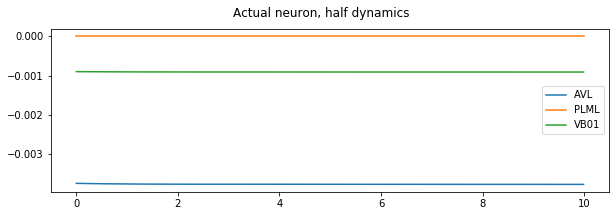

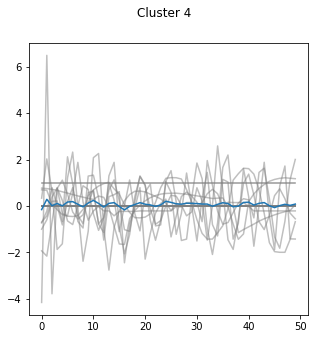

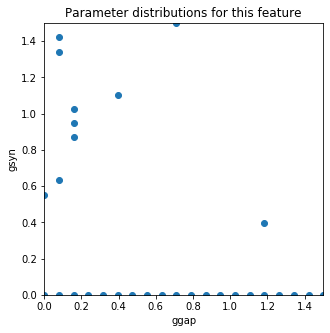

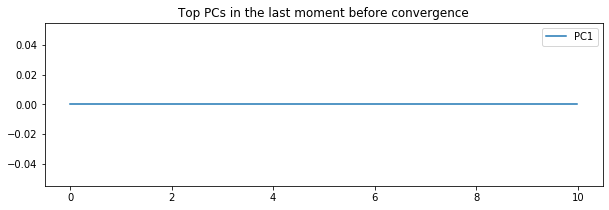

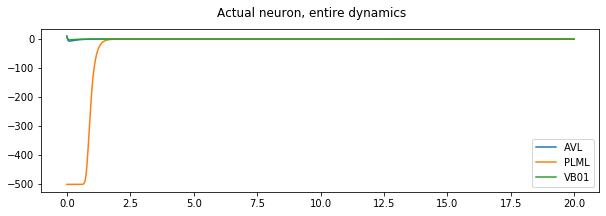

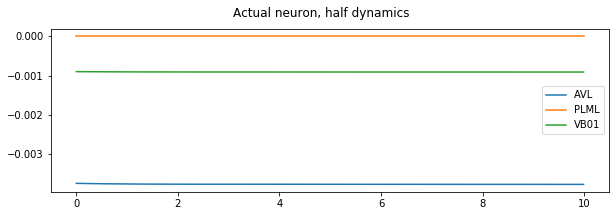

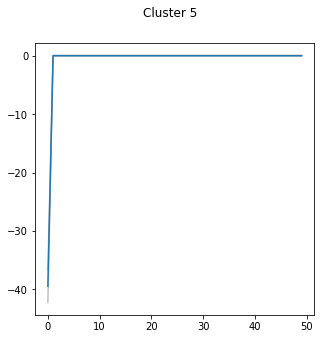

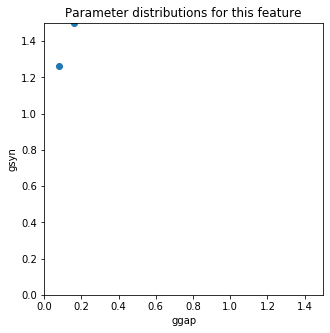

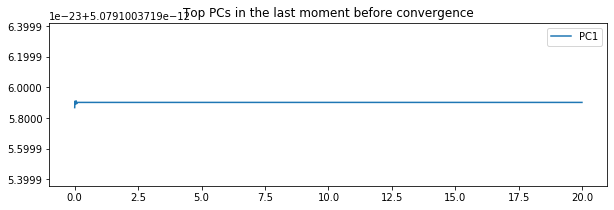

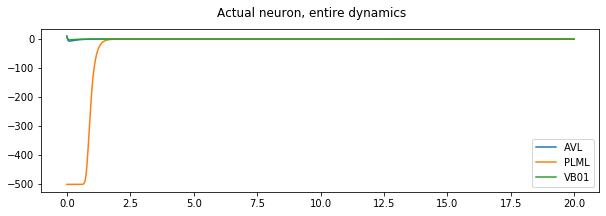

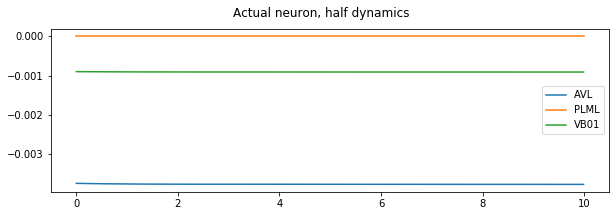

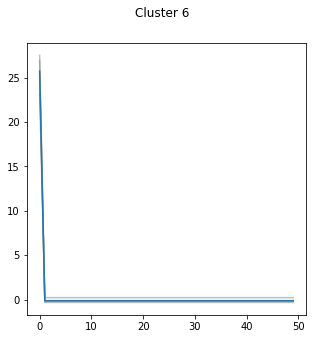

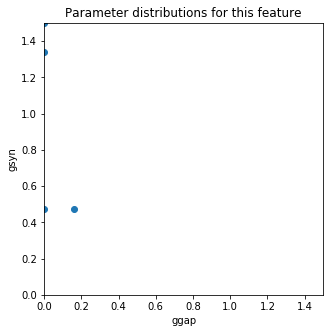

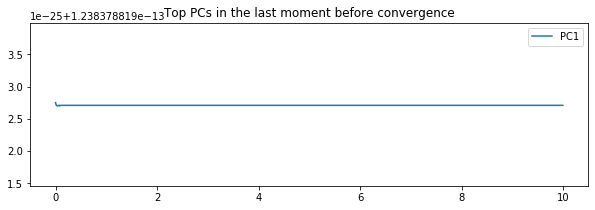

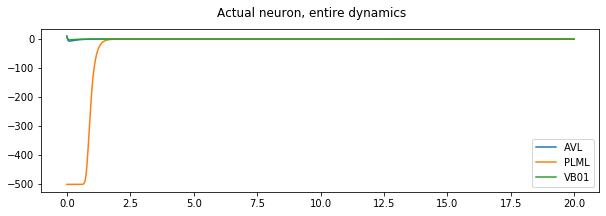

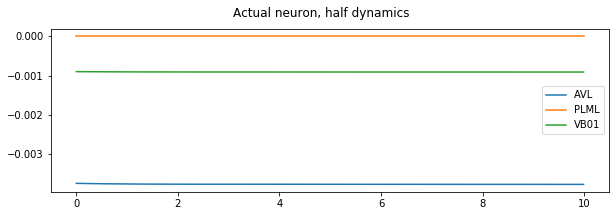

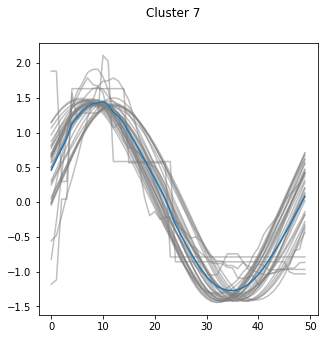

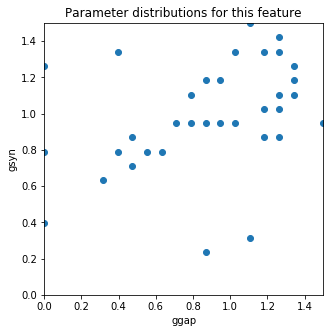

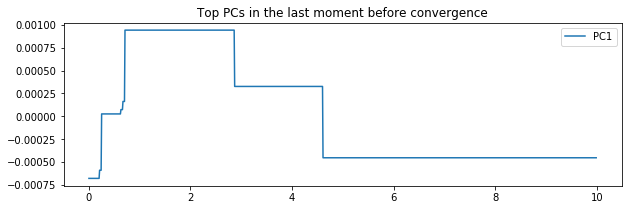

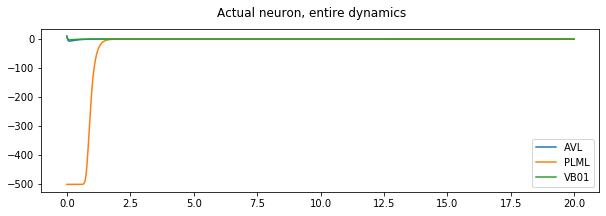

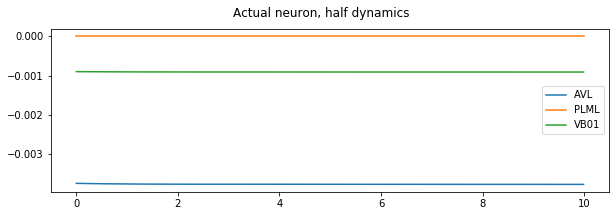

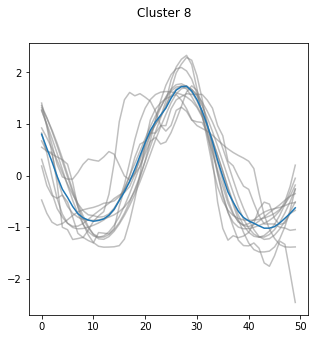

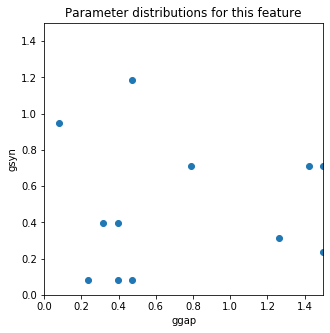

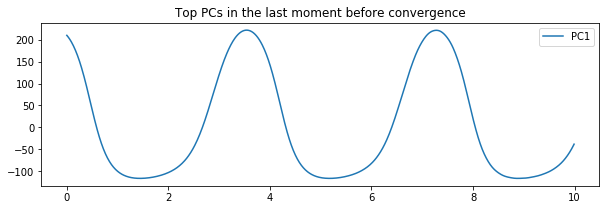

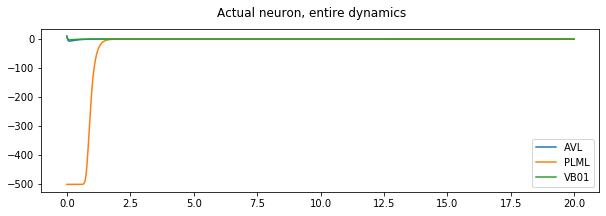

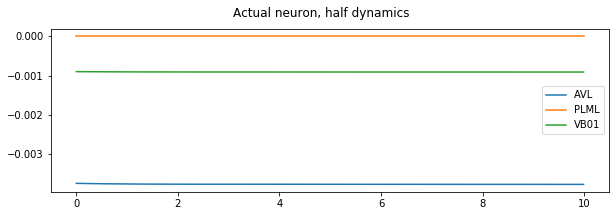

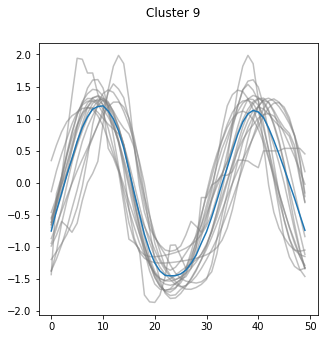

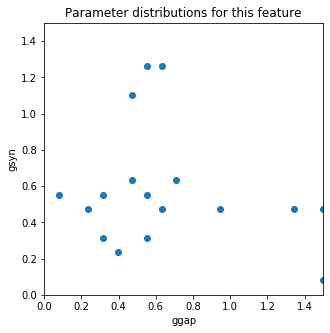

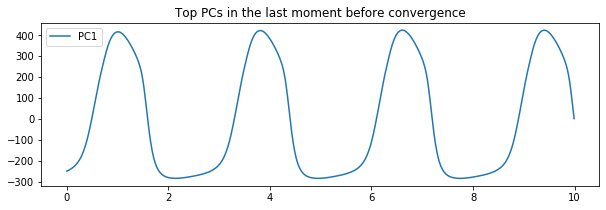

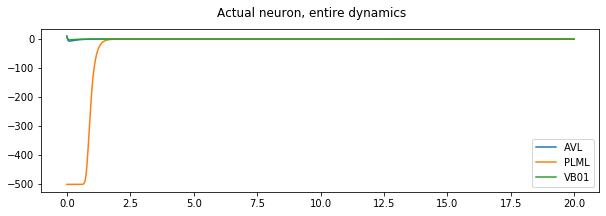

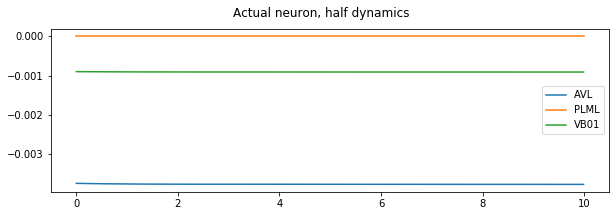

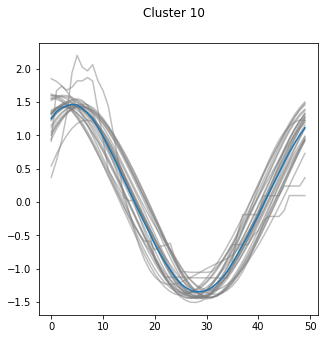

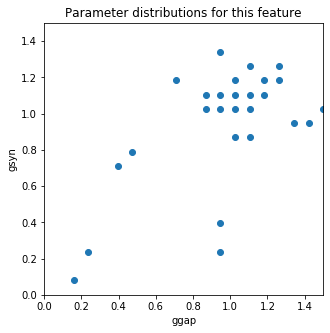

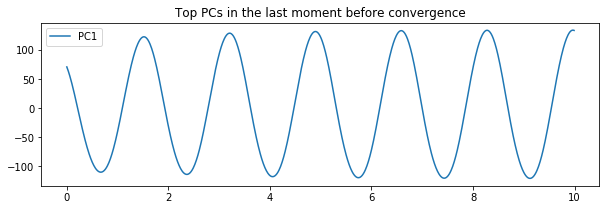

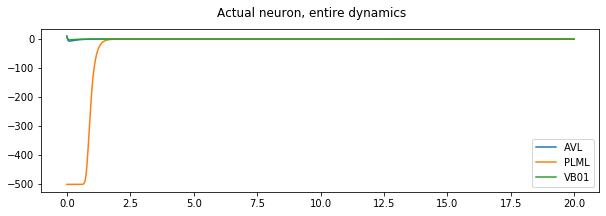

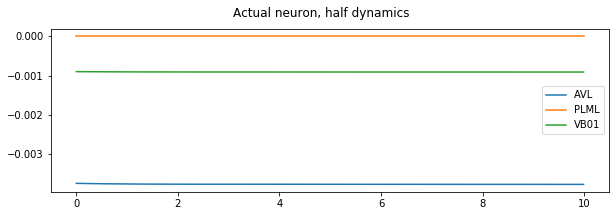

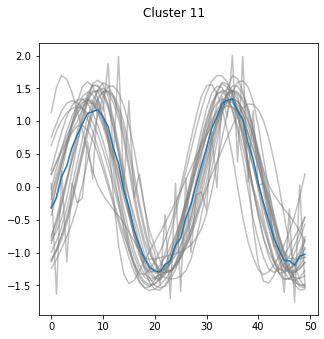

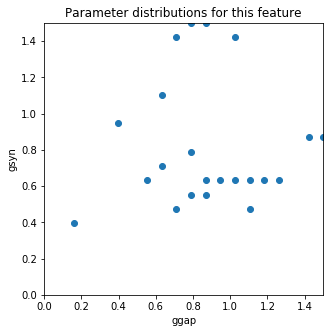

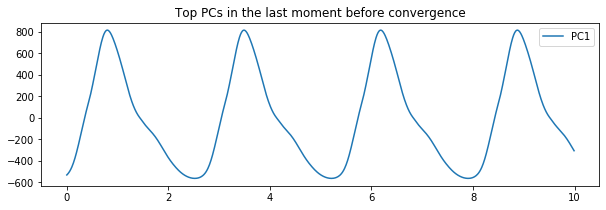

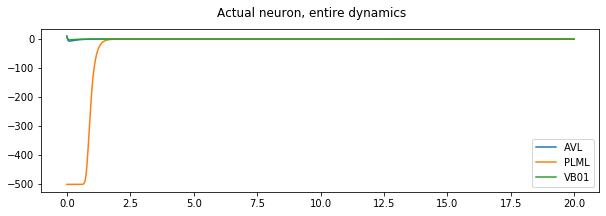

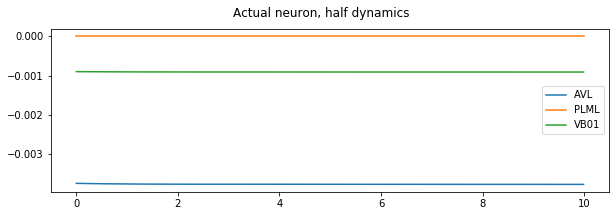

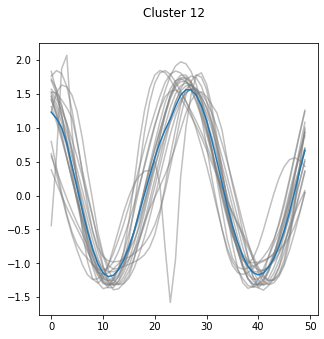

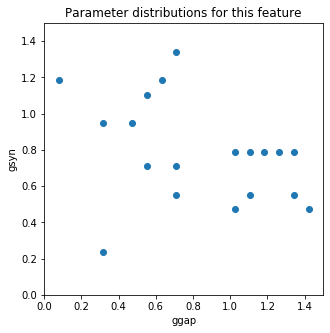

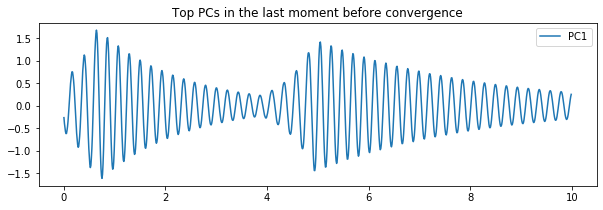

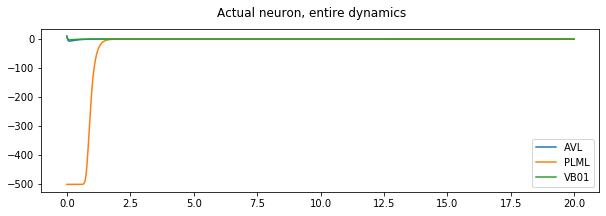

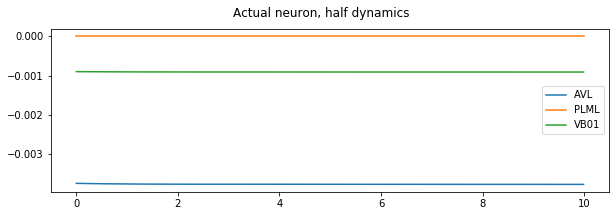

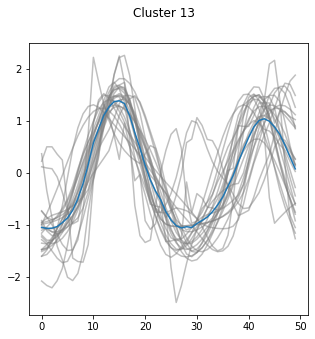

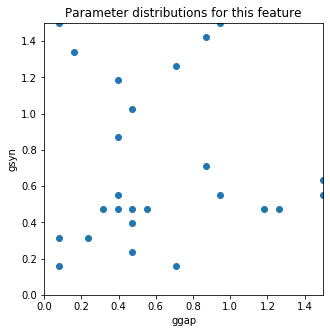

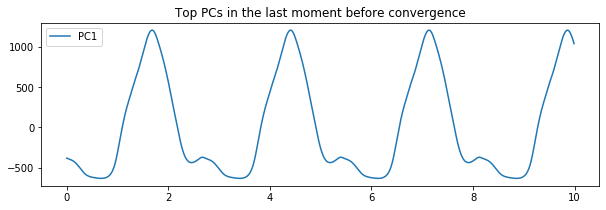

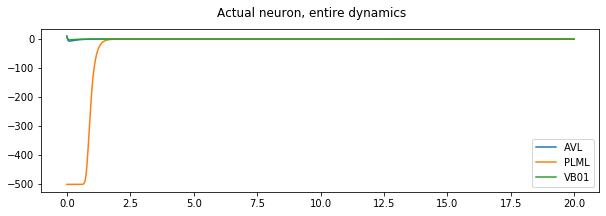

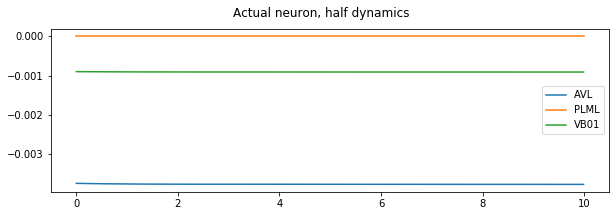

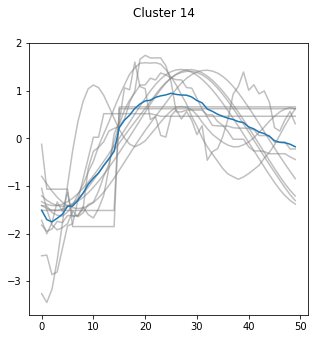

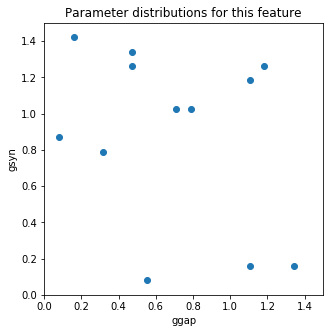

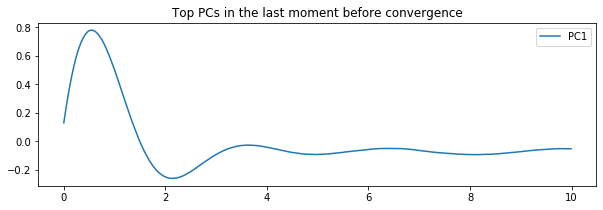

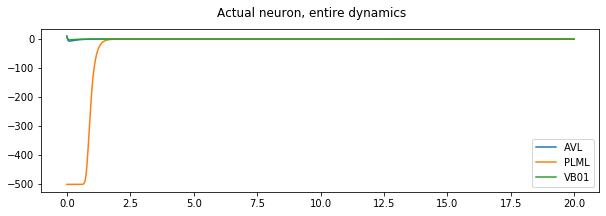

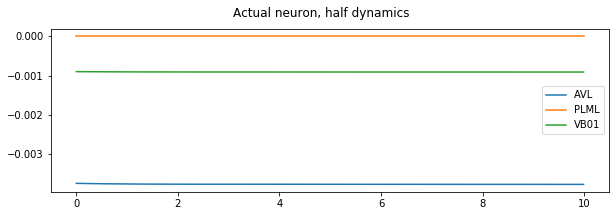

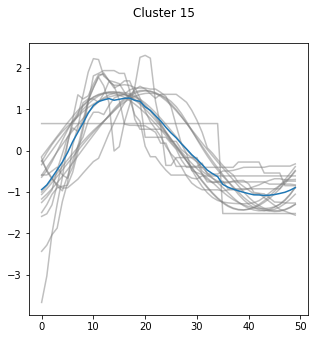

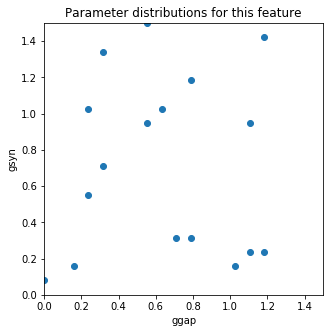

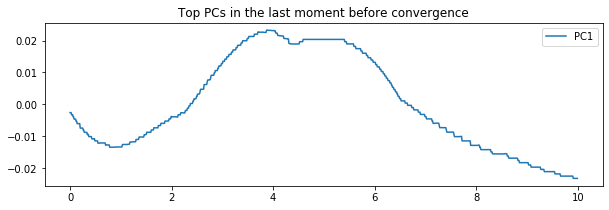

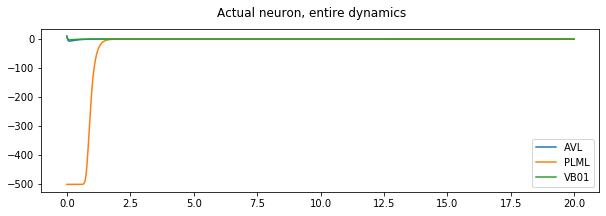

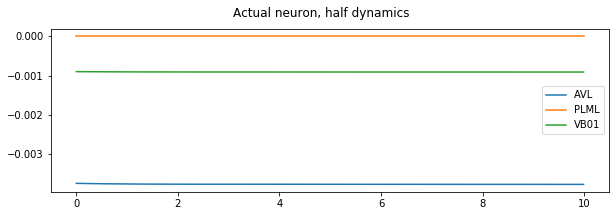

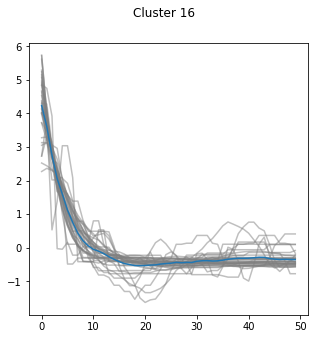

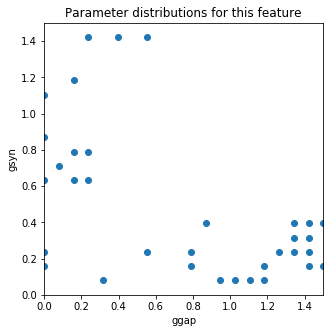

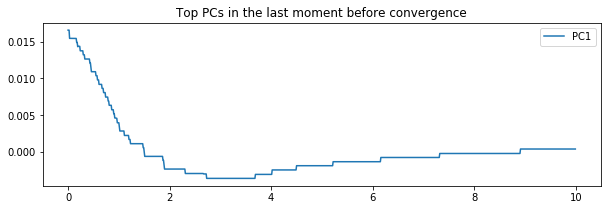

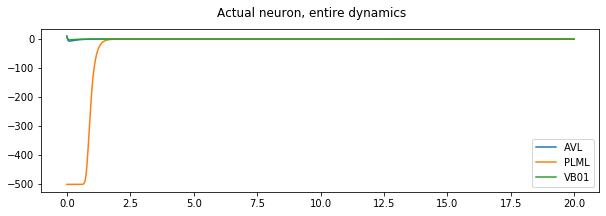

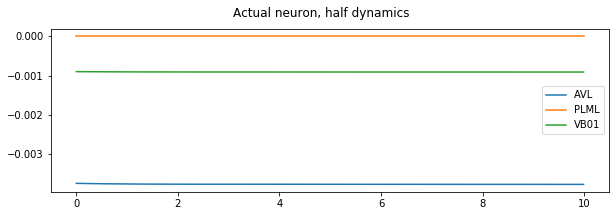

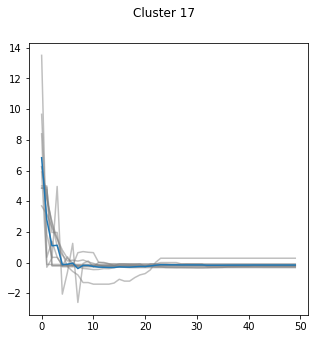

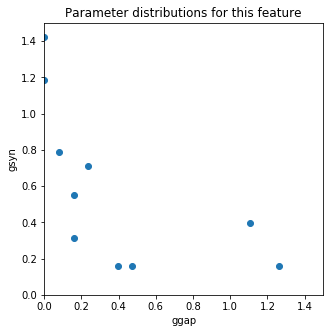

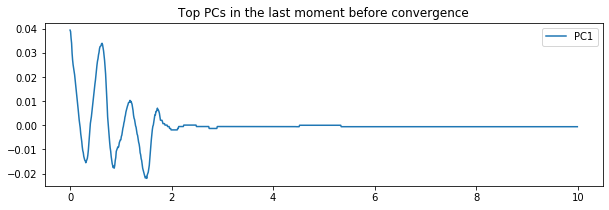

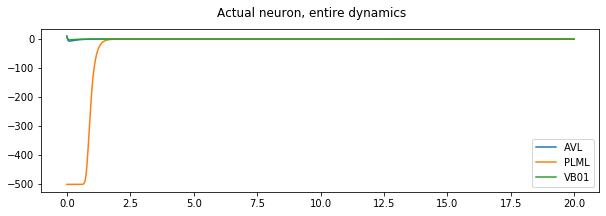

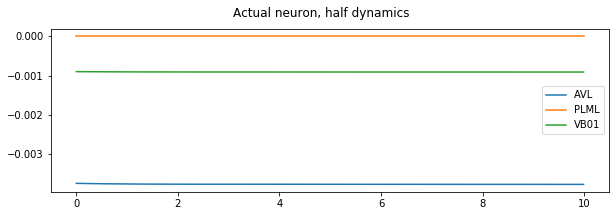

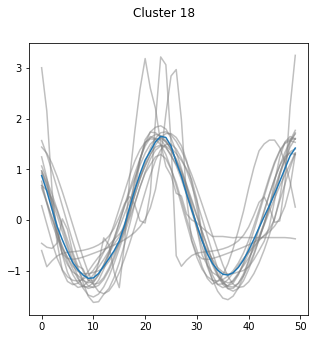

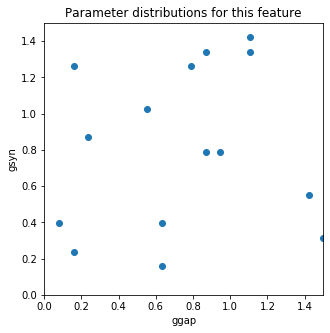

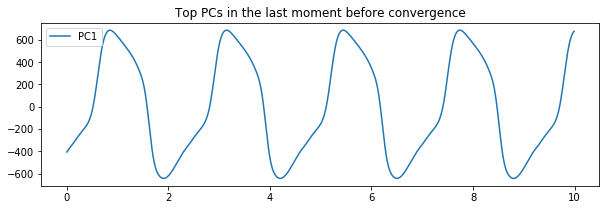

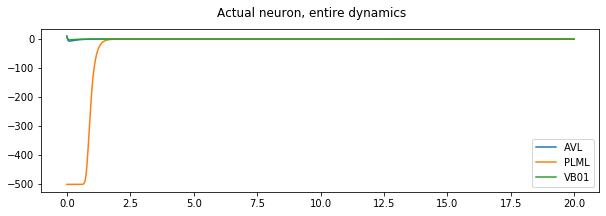

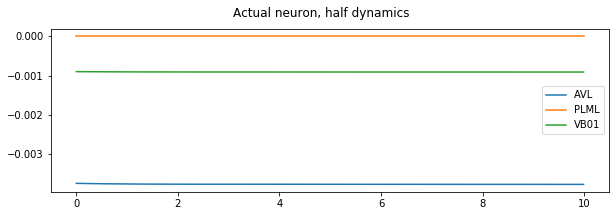

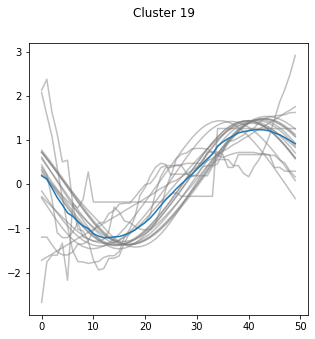

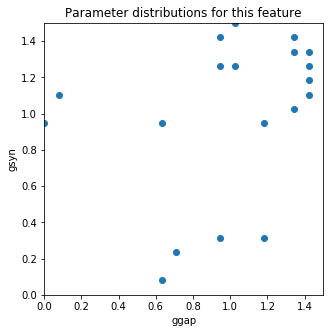

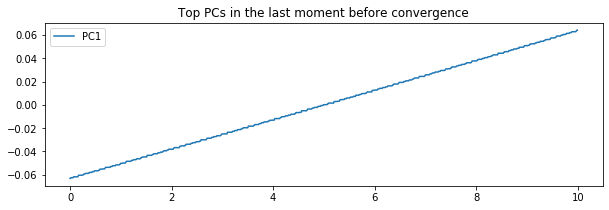

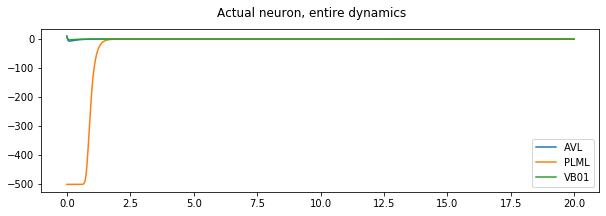

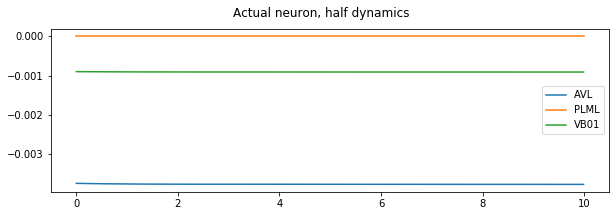

In [79]:
n_clusters = 20
params_list = np.array(params_list)

seed = 2
np.random.seed(seed)

km = TimeSeriesKMeans(n_clusters=n_clusters,
                      verbose=True,
                      random_state=seed
                      # Using euclidean is much faster and seems good enough.
                      #metric="softdtw",
                      #metric_params={"gamma_sdtw": .01}
                     )    
cluster_labels = km.fit_predict(ts_list)
for cluster_id in range(n_clusters):
  # Plot cluster result
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  for ts in ts_list[cluster_labels == cluster_id]:
    # Individual ts
    ax.plot(ts, alpha=.5, c='gray')
  # Cluster center ts
  fig.suptitle("Cluster {0}".format(cluster_id))
  ax.plot(km.cluster_centers_[cluster_id])
  
  # Plot parameter distribution of this cluster
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  ggaps = []
  gsyns = []
  
  cluster_params_list = params_list[cluster_labels == cluster_id]
  for param in cluster_params_list:
    ggaps.append(param[0])
    gsyns.append(param[1])
  ax.scatter(ggaps, gsyns)
  ax.set_title("Parameter distributions for this feature")
  ax.set_xlabel("ggap")
  ax.set_ylabel("gsyn")
  ax.set_xlim(0, 1.5)
  ax.set_ylim(0, 1.5)
    
  sample_param = cluster_params_list[0]
  ggap = sample_param[0]
  gsyn = sample_param[1]
  
  dom_mode = get_dom_mode(ggap, gsyn)
  times = np.arange(0, len(dom_mode) * 0.01, 0.01)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
  ax.plot(times, dom_mode, label = "PC1")
  ax.legend()
  ax.set_title("Top PCs in the last moment before convergence")

  fig = plot_saved_dynamics_collapsed(['AVL', 'PLML', 'VB01'], all_dynamics, neuron_metadata_collection)
  fig.suptitle("Actual neuron, entire dynamics")
  fig = plot_saved_dynamics_collapsed(['AVL', 'PLML', 'VB01'], all_dynamics[int(-n/2):,], neuron_metadata_collection)
  fig.suptitle("Actual neuron, half dynamics")

In [68]:
# TODO: Cluster everyone by hand.
# Sinuous = [0, 2]
# Stable node = [1]
np.round([0.12343, 23.323], 2)

array([ 0.12, 23.32])